### Appendix E. Object Detection and Object Recognition

In **Appendix A**, **B**, and **C**, I have assessed the accuracy of a number of models for predicting household objects that belong to three categories (i.e., spoon, fork, and floss). The pre-trained VGG16 model outperforms the other three models (i.e., HOG/SVM, NN, and CNN). Thus, I will be using the VGG16 model for the final portion of this project.

In this section, unlabelled objects are discerned via contour detection and then identified using te selected VGG16 model.   

**Table of Contents**

1. Object detection/object recognition of a still image  
2. References  
3. Summary and Future Works  

### 1. Object detection/object recognition of a still image

1.1. Load model

In [1]:
#dynamically set tensorflow backend
#https://stackoverflow.com/questions/49121112/how-do-i-set-the-keras-backend-in-python-dynamically-when-loaded-using-superviso
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K

from keras.utils import np_utils

#set encoder
#https://datascience.stackexchange.com/questions/17516/how-to-deal-with-string-labels-in-multi-class-classification-with-keras
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

transformed_label = encoder.fit_transform(["floss", "fork", "spoon"])
#print(transformed_label) #check

#code is taken from: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
#load model
from keras.models import load_model
load_model=load_model('Models/vgg_weights-improvement-06-1.00.hdf5')
load_model #check

C:\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#test model

from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

test_image_paths=['Images/spoon_test.jpg','Images/fork_test.jpg','Images/floss_test.jpg']

for test_image_path in test_image_paths:
    # load an image from file
    image = load_img(test_image_path, target_size=(58,103))


    from keras.preprocessing.image import img_to_array
    # convert the image pixels to a numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #convert a 3D to a 4D array

    from keras.applications.vgg16 import preprocess_input
    # prepare the image for the VGG model
    image = preprocess_input(image)

    # predict the probability across all output classes
    yhat = load_model.predict(image)

    import numpy as np
    predicted_label=np.around(yhat.astype(float),0)
    print('The image is a: %s (prob: %s)' %(encoder.inverse_transform(predicted_label)[0], np.around(yhat.astype('float'),2)))

    import cv2

    #plot the image
    plt.imshow(cv2.imread(test_image_path))
    plt.axis('off')
    plt.show()

The image is a: spoon (prob: [[0. 0. 1.]])


<Figure size 640x480 with 1 Axes>

The image is a: fork (prob: [[0. 1. 0.]])


<Figure size 640x480 with 1 Axes>

The image is a: floss (prob: [[0.86 0.14 0.  ]])


<Figure size 640x480 with 1 Axes>

1.2. Detect objects via contours detection and feed object image into model

In [3]:
#resize with padding
#https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

def resize_w_padding(im, desired_size_list):

    """
    This function resizes the image and paste into a padded area to maintain aspect ratio during resize.
    This function requires a PIL image as an input and returns a PIl image.
    
    Inputs:
        im=a PIL image
        desired_size_list=desired image dimensions with a format [width,height]
    Returns:
        a PIL image
    """
    
    from PIL import Image, ImageOps

    #set the desired dimensions as specified by user
    desired_size = desired_size_list #w,h 368 
    
    #set the original image dimensions
    old_size = im.size  # old_size[0] is in (width, height) format

    #print('old size:', old_size) #check the original size

    #calculate resize ratio based on width and height. Select the minimum (i.e., the less extreme).
    ratio = min(float(desired_size[0])/(old_size[0]),float(desired_size[1])/(old_size[1])) #float(desired_size)/max(old_size)
    
    #new_size = tuple([int(x*ratio) for x in old_size]) #rather than expanding by ratio, you can just specify a tuple (width, height)
    new_size= tuple((int(i * ratio) for i in old_size)) #expand old size by multiplying with ratio  

    #print('ratio:', ratio) #check
    #print('new size:', new_size, type(new_size)) #check

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size[0], desired_size[1]))
    new_im.paste(im, ((desired_size[0]-new_size[0])//2,
                        (desired_size[1]-new_size[1])//2))

    #new_im.show() #check
    
    delta_w = desired_size[0] - new_size[0]
    delta_h = desired_size[1] - new_size[1]

    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(im, padding)

    #new_im.show() #check

    #print(new_im) #check

    return new_im

In [4]:
#classify.py

# import the necessary packages
from sklearn.externals import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def detect_recognize_objects(image_path, pct_w, pct_h): #use 0.5 and 0.02
    """
    This function detects and identifies objects with width and height equal or greater than 
    pct_w*image_width and pct_h*image_width. It uses contour detection method to detect objects and
    uses VGG16 model to recognize objects.
    
    Inputs:
        image_path=location of image with unlabelled objects
        pct_w=percent width of object w.r.t. image width in fraction (0-1)
        pct_h=percent width of object w.r.t. image height in fraction (0-1)
    Return:
        Show original image with rectangles drawn around identified objects
    """
        
    df=pd.DataFrame() #an empty DataFrame to store inventory
    
    try:
        
        # load the image and convert it to grayscale
        #image = cv2.imread('digits_data/images/umbc_zipcode.png') #specify image location
        image = cv2.imread(image_path) #specify image location
        #image = cv2.resize(image, (0,0), fx=0.1, fy=0.1)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # blur the image, find edges, and then find contours along
        # the edged regions
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(blurred, 30, 150)

        (_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # sort the contours by their x-axis position, ensuring
        # that we read the numbers from left to right
        cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in cnts], key = lambda x: x[1])

        # loop over the contours
        for (c, _) in cnts:
            # compute the bounding box for the rectangle
            (x, y, w, h) = cv2.boundingRect(c)
            #print(c.shape, x,y,w,h)
            # if the width is at least 7 pixels and the height
            # is at least 20 pixels, the contour is likely a digit
            #if w >= 120 and h >= 120:
            if w>=image.shape[0]*pct_w and h>=image.shape[1]*pct_h: #perfect using either 0.02,0.6 or 0.6,0.02
                # crop the ROI and then threshold the grayscale
                # ROI to reveal the digit
                #roi = gray[y:y + h, x:x + w]

                #----image manipulations within region of interest

                ##########predict and classify.
                #crop image
                #http://matthiaseisen.com/pp/patterns/p0202/
                from PIL import Image

                #http://blog.rolfvandam.nl/post/convert-between-pil-image-and-numpy/
                #1. change to pil image, so I can crop it
                roi_pil=Image.fromarray(image, mode='RGB' ) 
                roi_pil = roi_pil.crop((x, y, x+w, y+h))
                #print(type(roi)) #check

                #2. resize with padding to maintain aspect ratio
                #use the above function
                roi_pil=resize_w_padding(roi_pil,[103,58])

                #3. convert to numpy array
                #roi_np = np.array(roi_pil.getdata()).astype(np.float32).reshape((roi_pil.size[0],roi_pil.size[1],3))
                roi_np=np.asarray(roi_pil)

                #check
                #print('roi_np_shape:',roi_np.shape) 
                #plt.imshow(roi_np) 
                #plt.show()

                #4. reshape data for the model
                roi_np = roi_np.reshape((1, roi_np.shape[0], roi_np.shape[1], roi_np.shape[2])) #convert a 3D to a 4D array
                #print(roi_np.shape) #check

                #5. predict the cropped image
                # predict the probability across all output classes
                yhat = load_model.predict(roi_np)

                predicted_label=np.around(yhat.astype(float),0)
                print('The image is a: %s (prob: %s)' %(encoder.inverse_transform(predicted_label)[0], np.around(yhat.astype('float'),2)))

                #reshape and plot the image
                plt.imshow(roi_np.reshape(roi_np.shape[1], roi_np.shape[2], roi_np.shape[3]))
                plt.axis('off')
                plt.show()

                # draw a rectangle around the digit, the show what the
                # image was classified as
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

                ##########Add a text showing the prediction
                #cv2.putText(image, str(digit), (x - 10, y - 10),
                #    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
                cv2.imshow("image", image)
                #choose 0 is you want user to confirm every number being guessed. 
                #choose 1 if you want the program to automatically label all numbers

                #save into DataFrame: predicted image, probability, and image arrays
                df=pd.concat([df,pd.Series([encoder.inverse_transform(predicted_label)[0],np.around(yhat.astype('float'),2),
                                           roi_np])],axis=1, ignore_index=True)
                #df=df.append()

            cv2.waitKey(1) 
            cv2.destroyAllWindows()

        plt.imshow(image)
        plt.axis('off')
        plt.show()
    
        return df #returns pandas DataFrame
            
    except:
        pass
    


The image is a: floss (prob: [[1. 0. 0.]])


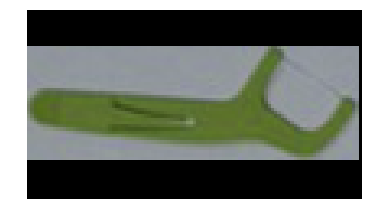

The image is a: floss (prob: [[1. 0. 0.]])


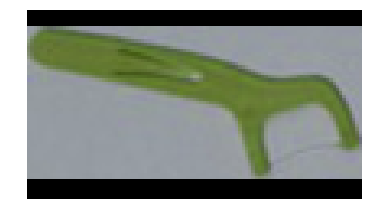

The image is a: floss (prob: [[1. 0. 0.]])


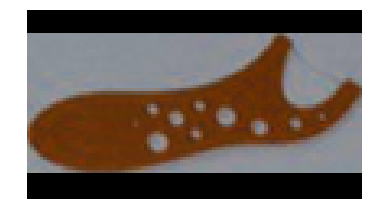

The image is a: floss (prob: [[1. 0. 0.]])


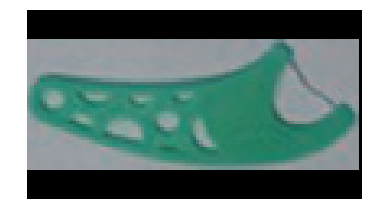

The image is a: floss (prob: [[1. 0. 0.]])


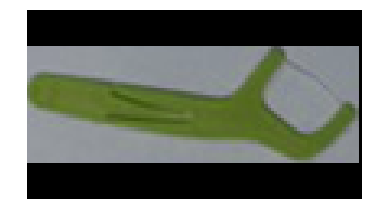

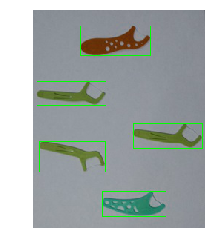

The image is a: spoon (prob: [[0. 0. 1.]])


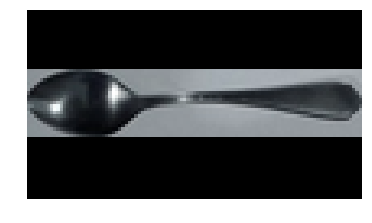

The image is a: spoon (prob: [[0. 0. 1.]])


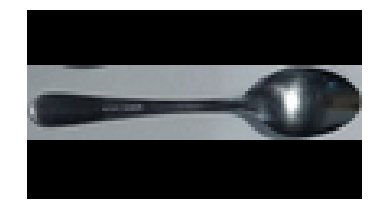

The image is a: spoon (prob: [[0. 0. 1.]])


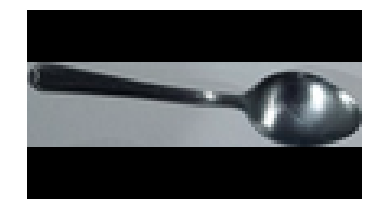

The image is a: spoon (prob: [[0.   0.01 0.99]])


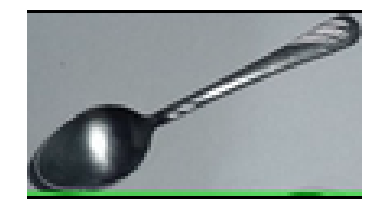

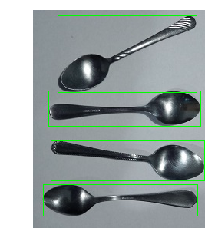

The image is a: fork (prob: [[0.   0.76 0.24]])


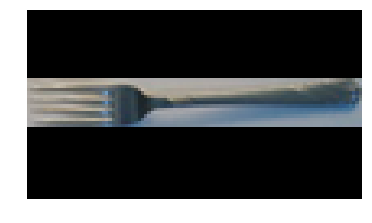

The image is a: spoon (prob: [[0. 0. 1.]])


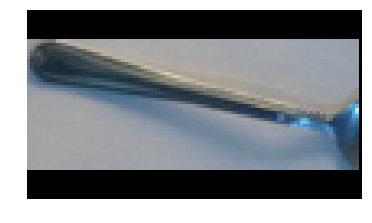

The image is a: fork (prob: [[0.01 0.99 0.  ]])


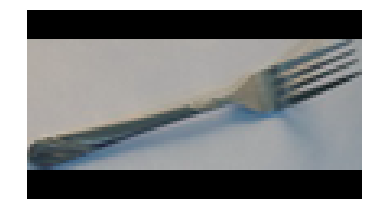

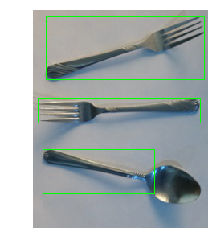

In [5]:
#Loop through images and append data to a single DataFrame

df_objects=pd.DataFrame() #an empty DataFrame for storing object information

for i in range(7):
    if i==0:
        df=detect_recognize_objects("Images/test_%sa.jpg" %(i+1), 0.2,0.02)
        df_objects=pd.concat([df_objects,df], axis=1, ignore_index=True)
        
    else:
        df=detect_recognize_objects("Images/test_%sa.jpg" %(i+1), 0.5,0.05)
        df_objects=pd.concat([df_objects,df], axis=1, ignore_index=True)


In [6]:
df_objects=df_objects.T
df_objects.columns=["Name", "Probability", "Image_array"] #rename columns
#df_objects #check

In [7]:
#sort by names
df_objects.sort_values(["Name"])

,Name,Probability,Image_array
0,floss,"[[1.0, 0.0, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
1,floss,"[[1.0, 0.0, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
2,floss,"[[1.0, 0.0, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
3,floss,"[[1.0, 0.0, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
4,floss,"[[1.0, 0.0, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
9,fork,"[[0.0, 0.76, 0.24]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
11,fork,"[[0.01, 0.99, 0.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
5,spoon,"[[0.0, 0.0, 1.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
6,spoon,"[[0.0, 0.0, 1.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
7,spoon,"[[0.0, 0.0, 1.0]]","[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."


In [8]:
#count number of objects

pd.value_counts(df_objects.Name)

floss    5
spoon    5
fork     2
Name: Name, dtype: int64

1.3. Check if automated labels are correct

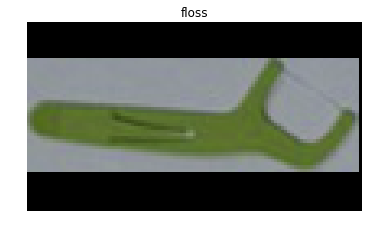

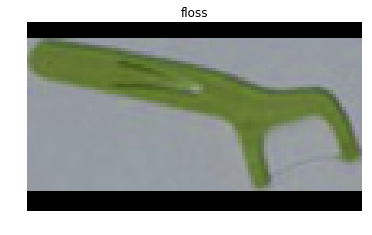

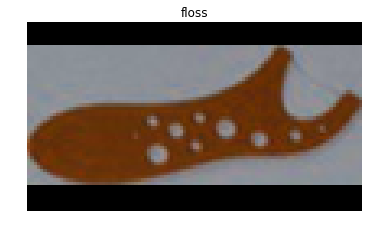

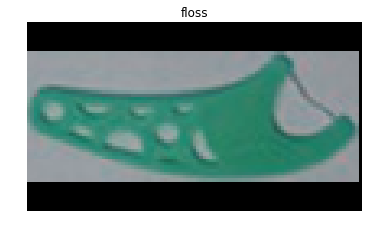

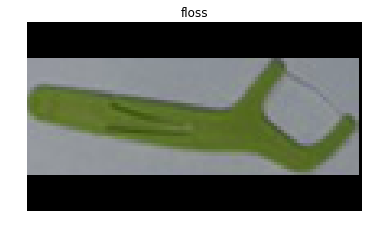

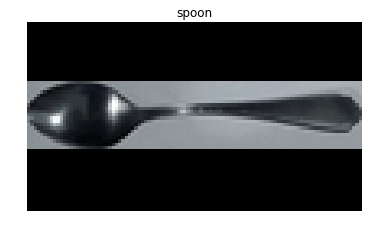

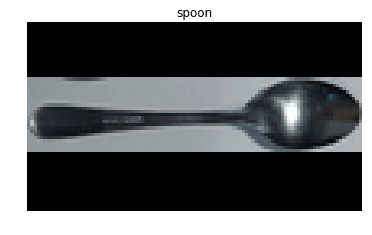

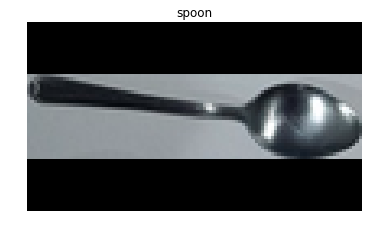

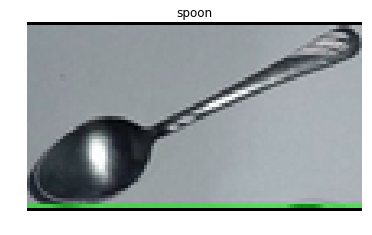

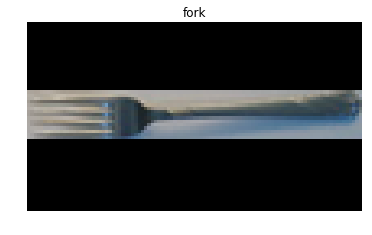

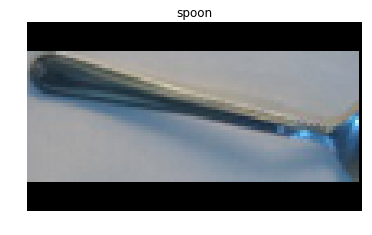

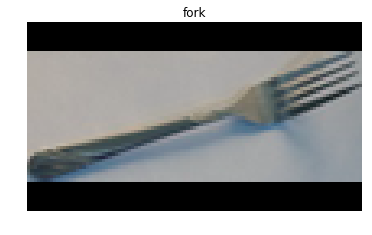

In [9]:
import matplotlib.pyplot as plt

for i in range(len(df_objects)):
    df_objects['Image_array'][i].shape #check
    plt.imshow(np.array(df_objects['Image_array'])[i].reshape(58,103,3))
    plt.axis('off')
    plt.title(df_objects.loc[i,'Name'])
    plt.show()

#### 2. References
 
1. "Practical python and openCV: case studies", Adrian Rosebrock, 2018.
2. Udemy, "Introduction to OpenCV", Rajeev.
3. https://www.youtube.com/watch?v=OnWIYI6-4Ss
4. Opencv 3.x with python by example, chpt 9: object recognition, packt.

#### 3. Summary and Future Works


- Given an image, I am able to detect objects, draw a rectangle around each object, and apply the object recognition model (VGG-16) developed in **Appendix D** to label the object. Finally, the labeled objects are entered into a pandas DataFrame. 
- Object detection is accomplished using contours detection. 
- However, object detection via contours detection requires the user to specify the object's aspect ratio.
- This method is not effective for an image that contains objects with different aspect ratios.
- There are alternative methods for object detection than contours detection, such as single shot 
  detection (SSD) and you only look once (YOLO). However, these methods require a GPU, which I don't have 
  access to.
- Another feasible alternative is to use the sliding window algorithm (https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/). However, like contours detection, it 
  requires the user to specify the object's aspect ratio. 

